## Steelman recommender system
This notebook is the workflow for a proof of concept for a recommender system that curates opposing opinions from a given input article. The text from articles have been scraped from the NYT and saved in a data frame.
1. Pre-processing text data - cleaning data for every document in the data frame (tokenization, lemmitization, removing stopwords).
2. Topic modeling - tried TFIDF with LSA and NMF. Ended up choosing NMF because the topics made more sense although the difference between them was small. 
3. K-means clustering - used k-means to cluster topics
4. Recommendation systems:
    - Cosine similarity and kmeans clustering
    - Cosine similarity and NMF
    - Cosine simlarity between documents
Cosine similarity with kmeans clustering seemed more on topic than the others so that was what I used for my final proof of concept. 

In [1]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from yellowbrick.text import TSNEVisualizer,UMAPVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

/Users/AuerPower/opt/miniconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import warnings
#warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [ ]:
# nltk.download('stopwords')
# nltk.download('wordnet')

## Pre-Processing text data

In [3]:
def preprocess(raw_text):
    
    # tokenize words
    tokenized_words = word_tokenize(raw_text)

    # keep only words - remove punctuation
    letters_only_text = [re.sub("[^a-zA-Z]", " ", text) for text in tokenized_words]

    # convert to lower case 
    words = [word.lower() for word in letters_only_text]

    # remove stopwords + useless words
    stopword_set = set(stopwords.words("english") + ['immigration'] + ['immigrants'])
    cleaned_words = list(set([w for w in words if w not in stopword_set]))
    
    # remove blank spaces from list
    cleaned_words = [re.sub(" ", "", text) for text in cleaned_words]
    cleaned_words = list(filter(None, cleaned_words))
    
    # Stem/lemmitize words
    #porter=PorterStemmer()
    #stemmed_words = [porter.stem(word) for word in cleaned_words]
    lemmatizer = WordNetLemmatizer()
    lemmitized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
    
    # put list of words back into a corpus doc
    cleaned_corpus = ' '.join(word for word in lemmitized_words)

    return cleaned_corpus

In [4]:
# Load data
article_df = pd.read_csv('data/immigration_2000.csv')
article_df['index'] = list(range(0,2000))

text_df = pd.read_csv('data/article_text/df_text_1892.csv', index_col=[0])

#article_df.tail()

In [5]:
# Merge data
text_df = text_df.merge(article_df, left_index=True, right_index=True, how='left')
text_df = text_df.reset_index()

In [6]:
text_df['all_text'] = [preprocess(row) for row in text_df['all_text']]

In [7]:
text_df['all_text'][0]

'elevated intends think decision consciousness subtracted joint house signal resurrect visit slaughter southeast percountry said country asiapacific decade saw nation certainly adding writes impulse surpassing reported myanmar implicated expanded chief free largest eliding haram impeachment hysteria followed johnsonreed chinese group environment percentage matter japanese came behavior racial stage want continues swamped respect tourist basis economy never list eritrea much responsible america called terrorist south would ineligible operation announced well law whiteness type asian legal billion cast element sends supreme africa citizenship society mulatto foreignness reconstitute attainment black vector nonwhites shithole permanent including complained around others notion still famously birth found immigration obvious cabinet racism member administration thousand hand revised setting travel become hierarchy sudan established worked long system nonwhite ignorant public could boundary 

In [8]:
print("number of articles in corpus:", text_df.shape[0])

number of articles in corpus: 1892


## Some EDA

In [ ]:
print("number of articles in corpus:", text_df.shape[0])

In [ ]:
## What is the span of dates for our dataset? 
article_df['pub_date'] = pd.to_datetime(article_df['pub_date'])
article_years = article_df.reset_index().set_index('pub_date').resample('Y').size()
article_years

In [ ]:
text_df['pub_date'] = pd.to_datetime(text_df['pub_date'])
text_df = text_df[text_df['pub_date'] > '2005-12-31 00:00:00+00:00']
text_df.shape

Articles go back really far. I might try to get more articles and cut it off to just the past 5 or 10 years.

## Topic Modeling

#### TFIDF with LSA

In [142]:
#vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english')
vectorizer=TfidfVectorizer(use_idf=True, stop_words='english')
doc_word = vectorizer.fit_transform(text_df['all_text'])
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(doc_word)
topic_word = pd.DataFrame(lsa.components_.round(3),
             columns = vectorizer.get_feature_names())

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
display_topics(lsa, vectorizer.get_feature_names(), 30)


Topic  0
year, state, american, country, law, republican, policy, right, time, make, family, border, president, people, million, mr, way, like, child, government, need, new, day, want, say, work, united, said, issue, come

Topic  1
court, deportation, law, enforcement, federal, criminal, judge, department, homeland, administration, officer, agency, custom, abuse, lawyer, agent, police, official, justice, crime, detention, local, security, case, arrest, legal, profiling, arizona, supreme, jail

Topic  2
refugee, migrant, life, family, mother, child, home, yearold, parent, father, story, asylum, day, friend, daughter, european, world, girl, violence, woman, europe, arrived, son, kid, fleeing, human, told, el, journey, born

Topic  3
worker, visa, reform, million, job, labor, employer, wage, pay, economy, comprehensive, path, card, work, citizenship, family, senate, billion, business, dream, workplace, shadow, temporary, bipartisan, senator, green, better, program, fix, mexico

Topic  4


#### TFIDF and NMF

In [9]:
from sklearn.decomposition import NMF

#n_samples = 2000
n_features = 5000
n_topics = 10
n_top_words = 30

vectorizer = TfidfVectorizer(max_df=0.95, # ignores terms that appear in more than 95% of the documents
                             min_df=0.01, # ignore terms that appear in less than 1% of the documents
                             max_features=n_features,
                             stop_words='english')

tfidf = vectorizer.fit_transform(text_df['all_text'].values)

# Fit the NMF model
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)

feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic #0:
liberal white voter conservative election view minority issue democrat race group party politics candidate democratic poll vote black survey progressive percentage point hispanic electorate majority question republican political shift identity

Topic #1:
court supreme judge justice case ruling decision appeal law state federal constitution constitutional power circuit ruled statute opinion authority argument order claim united upheld branch district executive right government attorney

Topic #2:
day life friend family story know father school home mother child told woman came tell feel time parent son american got born daughter year love later kid man america place

Topic #3:
european europe minister refugee union muslim party france prime leader britain germany german populist movement french british country italy parliament attack nation political merkel world angela chancellor referendum western war

Topic #4:
economy tax job economic wage rate population business worker i

In [10]:
# Topic matrix
nmf_T = nmf.fit_transform(tfidf)
nmf_T.shape

(1892, 10)

In [11]:
# Topic matrix as pandas data frame
nmf_df = pd.DataFrame(nmf_T)
nmf_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.026356,0.062075,0.030525,0.062783,0.023964,0.000000,0.033158,0.000000,0.000016,0.001263
1,0.008301,0.099741,0.019963,0.000000,0.035693,0.028004,0.016910,0.014511,0.007737,0.026034
2,0.012514,0.043139,0.042167,0.000000,0.005944,0.110414,0.000000,0.000000,0.028160,0.037365
3,0.068229,0.003918,0.028599,0.008192,0.030621,0.051213,0.075774,0.023339,0.000000,0.007241
4,0.016868,0.053054,0.003050,0.000000,0.021304,0.037905,0.000000,0.000000,0.000000,0.127137


In [12]:
# Get the average of features/weights for each topic
for topic in range(0,10):
    avg = nmf_df[topic].mean()
    print("topic ", topic, "=", avg)

topic  0 = 0.017360558944763252
topic  1 = 0.020697125126184945
topic  2 = 0.03215776444498528
topic  3 = 0.02015222205651698
topic  4 = 0.02656165440820483
topic  5 = 0.02183373202394291
topic  6 = 0.02095271625685808
topic  7 = 0.02665863203362115
topic  8 = 0.019498995867738733
topic  9 = 0.024335078964818836


In [13]:
# Assign a topic to each document
nmf_df['topic'] = nmf_df.idxmax(axis=1)
nmf_df.head()

,0,1,2,3,4,5,6,7,8,9,topic
0,0.026356,0.062075,0.030525,0.062783,0.023964,0.000000,0.033158,0.000000,0.000016,0.001263,3
1,0.008301,0.099741,0.019963,0.000000,0.035693,0.028004,0.016910,0.014511,0.007737,0.026034,1
2,0.012514,0.043139,0.042167,0.000000,0.005944,0.110414,0.000000,0.000000,0.028160,0.037365,5
3,0.068229,0.003918,0.028599,0.008192,0.030621,0.051213,0.075774,0.023339,0.000000,0.007241,6
4,0.016868,0.053054,0.003050,0.000000,0.021304,0.037905,0.000000,0.000000,0.000000,0.127137,9


The average weights of each topic are relatively the same so this means I can assign each document to a topic based on the index (topic) associated with the largest coefficient in the nmf array for each document.

In [14]:
# Name topics
topic_names = {0:"Elections", 1:"Law", 2:"Family", 3:"Identity", 4:"Europe", 
               5:"Enforcement", 6:"Labor", 7:"Border", 8:"Citizenship", 9:"Refugees"}
nmf_df['topic'] = nmf_df['topic'].map(topic_names)
nmf_df.head()

,0,1,2,3,4,5,6,7,8,9,topic
0,0.026356,0.062075,0.030525,0.062783,0.023964,0.000000,0.033158,0.000000,0.000016,0.001263,Identity
1,0.008301,0.099741,0.019963,0.000000,0.035693,0.028004,0.016910,0.014511,0.007737,0.026034,Law
2,0.012514,0.043139,0.042167,0.000000,0.005944,0.110414,0.000000,0.000000,0.028160,0.037365,Enforcement
3,0.068229,0.003918,0.028599,0.008192,0.030621,0.051213,0.075774,0.023339,0.000000,0.007241,Labor
4,0.016868,0.053054,0.003050,0.000000,0.021304,0.037905,0.000000,0.000000,0.000000,0.127137,Refugees


Text(0, 0.5, '')

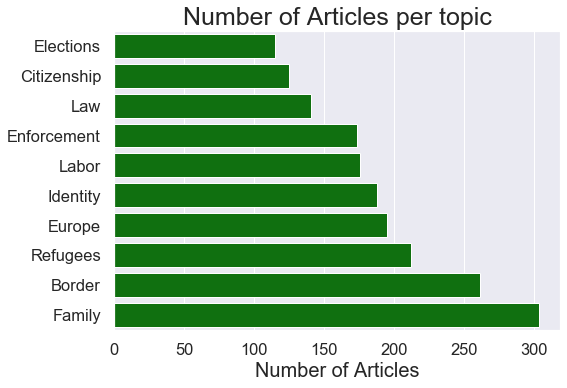

In [15]:
## graph of topic contributions
import seaborn as sns
import matplotlib.pyplot as plt

topic_sum = nmf_df.groupby('topic').size()
topic_sum = topic_sum.to_frame(name='docs')
topic_sum = topic_sum.reset_index()
topic_sum = topic_sum.sort_values('docs')

# plot
sns.set(font_scale = 1.5)
ax = sns.barplot(x='docs', y='topic', data=topic_sum, color='green')
ax.axes.set_title("Number of Articles per topic",fontsize=25)
ax.set_xlabel("Number of Articles",fontsize=20)
ax.set_ylabel("")

In [16]:
# Merge topics with main text dataframe
topics_index = nmf_df['topic']
text_df = text_df.merge(topics_index, left_index=True, right_index=True)
text_df.head()

,level_0,all_text,Unnamed: 0,abstract,web_url,snippet,lead_paragraph,source,headline,pub_date,document_type,news_desk,section_name,index,topic
0,0,elevated intends think decision consciousness ...,0,Adding Nigeria to the expanded list of exclude...,https://www.nytimes.com/2020/02/04/opinion/tru...,Adding Nigeria to the expanded list of exclude...,It’s happening a little bit out of public cons...,The New York Times,The Racism at the Heart of Trump’s ‘Travel Ban’,2020-02-04T10:00:15+0000,article,OpEd,Opinion,0,Identity
1,1,deeply specific uproot advancement urgent deci...,1,Congressional hearings are urgently needed to ...,https://www.nytimes.com/2020/02/07/opinion/dhs...,Congressional hearings are urgently needed to ...,“When the government tracks the location of a ...,The New York Times,The Government Uses ‘Near Perfect Surveillance...,2020-02-08T00:24:47+0000,article,Editorial,Opinion,1,Law
2,2,purported falsified gangrelated happened shirt...,2,The bar for being labeled a gang member is low...,https://www.nytimes.com/2020/02/03/opinion/los...,The bar for being labeled a gang member is low...,I found out I was in a gang database — a share...,The New York Times,Are You in a Gang Database?,2020-02-04T00:00:07+0000,article,OpEd,Opinion,2,Enforcement
3,3,tended draconian think florida initiative marg...,3,Immigration can invigorate the country. But wh...,https://www.nytimes.com/2020/01/16/opinion/imm...,Immigration can invigorate the country. But wh...,"In 2001, when I was the new Washington corresp...",The New York Times,I’m a Liberal Who Thinks Immigration Must Be R...,2020-01-16T23:48:30+0000,article,OpEd,Opinion,3,Labor
4,4,tone political low isolation requirement red w...,4,"For immigrants languishing behind bars, a hung...",https://www.nytimes.com/2020/01/30/opinion/hun...,"For immigrants languishing behind bars, a hung...","On Jan. 29, Immigration and Customs Enforcemen...",The New York Times,Starving for Justice in ICE Detention,2020-01-30T20:30:07+0000,article,OpEd,Opinion,4,Refugees


In [17]:
text_df.shape

(1892, 15)

#### Visualize topic clusters

In [18]:
# Visualization
import seaborn as sns
sns.set(style='white', palette="bright", context='notebook', rc={'figure.figsize':(14,10)})

Valid metrics are ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski', 'nan_euclidean', 'haversine']

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

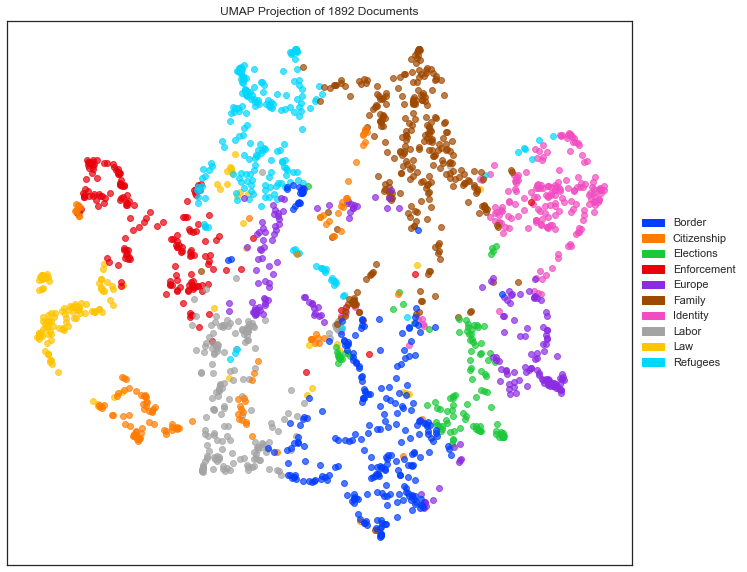

In [19]:
# Use UMAP to visualize topic clusters in two dimensional space
docs = nmf_T
labels = nmf_df['topic']

# Instantiate the text visualizer
umap = UMAPVisualizer(metric='euclidean')
umap.fit(docs, labels)
umap.show(outpath='/Users/AuerPower/Metis/git/steel-man/outputs/topic-cluster2.svg')

## Clustering with K-means

K-means allows me to include a mix of topics in cluster. Just taking the maximum value of a topic matrix could be assigning a topic that is actually really close to another topic, which would be potentially excluding relevant articles from the recommender system. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

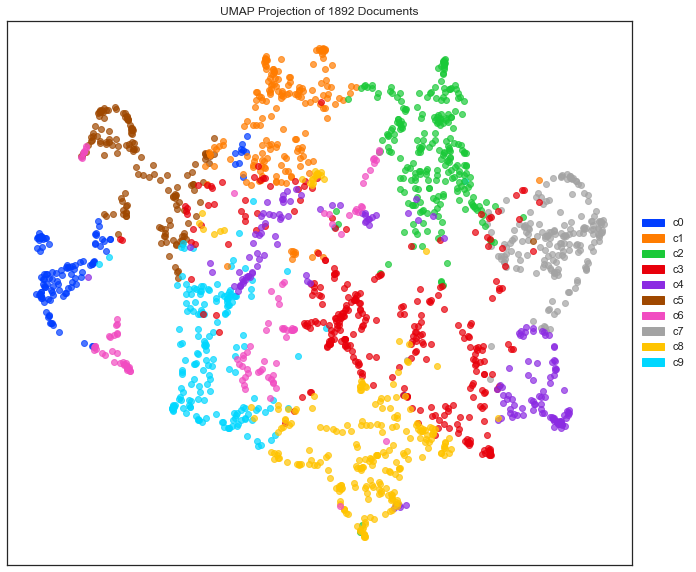

In [20]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import UMAPVisualizer
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

# Load the text data
docs = nmf_T

# Instantiate the clustering model
clusters = KMeans(n_clusters=10, n_jobs = -1, random_state = 42)
clusters.fit(docs)

umap = UMAPVisualizer() 
umap.fit(docs, ["c{}".format(c) for c in clusters.labels_])
umap.show(outpath='/Users/AuerPower/Metis/git/steel-man/outputs/kmeans-cluster2.svg')
#umap.save(, format='svg', transparent=True)

In [21]:
# Create data frame to which topic ended up in which clusters
cluster_df = pd.DataFrame.from_dict({'headline':text_df['headline'],
                                     'snippet':text_df['snippet'],
                                     'topic':text_df['topic'], 
                                     'cluster':clusters.labels_})
cluster_df.head()

,headline,snippet,topic,cluster
0,The Racism at the Heart of Trump’s ‘Travel Ban’,Adding Nigeria to the expanded list of exclude...,Identity,7
1,The Government Uses ‘Near Perfect Surveillance...,Congressional hearings are urgently needed to ...,Law,0
2,Are You in a Gang Database?,The bar for being labeled a gang member is low...,Enforcement,5
3,I’m a Liberal Who Thinks Immigration Must Be R...,Immigration can invigorate the country. But wh...,Labor,9
4,Starving for Justice in ICE Detention,"For immigrants languishing behind bars, a hung...",Refugees,1


In [22]:
# plot the topics within each cluster
# Export this table as csv and use tableau to create a stacked bar chart
cluster_df.to_csv('/Users/AuerPower/Metis/git/steel-man/outputs/cluster_df.csv')

## Recommender system
I tried threes different types of recommendation systems
1. Cosine similarity and kmeans clustering
2. Cosine similarity and NMF 
3. cosine simlarity between documents

#### K-means cosine recommender system

In [23]:
# Create cluster matrix
cluster_matrix = clusters.transform(docs)

In [24]:
cluster_matrix_df = pd.DataFrame(cluster_matrix)
cluster_matrix_df['cluster'] = clusters.labels_
cluster_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,cluster
0,0.106000,0.145117,0.119623,0.081870,0.126665,0.153568,0.151435,0.079477,0.131666,0.114844,7
1,0.050953,0.129131,0.136550,0.100705,0.131016,0.131686,0.144963,0.147169,0.130239,0.127600,0
2,0.136179,0.135408,0.132979,0.119858,0.165606,0.051504,0.145490,0.160964,0.152944,0.152814,5
3,0.166461,0.155586,0.135290,0.085815,0.129152,0.122701,0.156899,0.140929,0.118223,0.081421,9
4,0.143841,0.055000,0.169384,0.132960,0.164104,0.151782,0.179387,0.168196,0.165475,0.165253,1


In [25]:
indices = pd.Series(text_df['headline'])

In [26]:
# recommender by cosine similarity within cluster
def recommend_kmeans(headline):
    recommended_steelmen = []
    # get index of the article headline
    idx = indices[indices == headline].index[0]
    # get topic of article
    topic_of_article = cluster_matrix_df.cluster[idx]
    # get all articles of the same topic and drop topic column
    topic_set = cluster_matrix_df[cluster_matrix_df.cluster == topic_of_article].drop('cluster', axis=1)
    # calculate cosine similarity on data frame and select array for article
    cosine_calc = cosine_similarity(topic_set)
    # sort values
    score_series = pd.Series(cosine_calc[0]).sort_values(ascending = True) # this is returning in order of least similar
    top_10_indices = list(score_series.iloc[1:11].index)
    
    for i in top_10_indices:
        #recommended_steelmen.append(list(cluster_df['headline'], cluster_df['snippet'])[i])
        recommended_steelmen.append([cluster_df['headline'][i], cluster_df['snippet'][i]])
        
    return recommended_steelmen

In [27]:
recommend_kmeans('Slouching Toward Eurabia?')

[['A Few Simple Truths on Immigration',
  'Careful examination of the facts undermines the claims of Donald Trump and his allies.'],
 ['God Bless America, and Her Lawyers',
  '‘It’s like someone is running around sticking their finger in people’s eyes and I’m an eye doctor.’'],
 ['On Immigration, the Democrats Are Playing Into Trump’s Hands',
  'Rather than present tough choices and coherent ideas, they are mostly responding to his outrages with empty rhetoric.'],
 ['Fixing Immigration From the Ground Up',
  'As Washington keeps failing on immigration reform, hopefuls can look to California for an enlightened example.'],
 ['Mrs. Clinton’s Mixed Immigration Message',
  'Showing full support for a bill that would ensure legal support for children at the border would help to clarify the candidate’s view.'],
 ['The Injustice of This Moment Is Not an ‘Aberration’',
  'From mass incarceration to mass deportation, our nation remains in deep denial.'],
 ['Readers: Join a Conversation About Imm

#### NMF and cosine similarity recommender system

In [97]:
# recommender by cosine similarity within topic
def recommend(headline):
    recommended_steelmen = []
    # get index of the article headline
    idx = indices[indices == headline].index[0]
    # get topic of article
    topic_of_article = nmf_df.topic[idx]
    # get all articles of the same topic and drop topic column
    topic_set = nmf_df[nmf_df.topic == topic_of_article].drop('topic', axis=1)
    # calculate cosine similarity on data frame and select array for article
    cosine_calc = cosine_similarity(topic_set)
    # sort values
    score_series = pd.Series(cosine_calc[0]).sort_values(ascending = True) # this is returning in order of least similar
    top_10_indices = list(score_series.iloc[1:11].index)
    
    for i in top_10_indices:
        #recommended_steelmen.append(list(text_df['headline'])[i])
        recommended_steelmen.append([text_df['headline'][i], text_df['snippet'][i]])
        
    return recommended_steelmen

#biggest_topic_set = nmf_df[nmf_df.topic_y == biggest_topic]
#cosine_sim = cosine_similarity(nmf_T[biggest_topic_set.index])

In [117]:
recommend('Slouching Toward Eurabia?')

[['Britain’s Flawed Immigration Strategy',
  'Warnings that Britain will be overrun are exaggerated and counterproductive.'],
 ['A Cool Head on Immigration',
  'Gov. Janet Napolitano of Arizona would be a solid choice for homeland security secretary. She has a strong understanding of immigration and its political traps.'],
 ['Immigration and the Elections',
  'David Shipley, the Op-Ed editor, speaks with Lawrence Downes, an editorial writer, about the immigration issues that have played out in this election cycle.'],
 ['Meet Memo, the Marie Kondo of Fitness',
  'In a cluttered world of boutique fitness studios and high-end gear, Guillermo Piñeda Morales reminds us that we don’t need much to be our best.'],
 ['I’m a Liberal Who Thinks Immigration Must Be Restricted',
  'Immigration can invigorate the country. But when it is poorly managed, it can cause social division — just as it’s doing right now.'],
 ['The Immigration Bill Presses On',
  'After two weeks of markup, the fundamental su

#### recommender by cosine similarity only

In [61]:
cosine_sim = cosine_similarity(nmf_T)

In [62]:
# recommender by cosine similarity only
def recommend2(headline, cosine_sim = cosine_sim):
    recommended_steelmen = []
    idx = indices[indices == headline].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = True) # this is returning in order of least similar
    top_10_indices = list(score_series.iloc[0:10].index)
    
    for i in top_10_indices:
        recommended_steelmen.append(list(text_df['headline'])[i])
        
    return recommended_steelmen

In [64]:
recommend2('The Racism at the Heart of Trump’s ‘Travel Ban’')

['The Retro Futurism of Marco Rubio',
 'Pulling Back the Immigration Posses',
 'Jeb Bush Openly Runs for President, Finally',
 'Praise for Bush’s Treasury Choice',
 'Could Ted Cruz Win?',
 'Donald Trump Is Focus of Attacks in the Republican Debate',
 'Could Donald Trump Be Good for Republicans?',
 'Georgia Republicans Know Exactly Who’s at Fault for Gridlock',
 'California’s Trust Act',
 'Confusion Over Secure Communities']